# Mesh example: Simple geometry

Shows how to create simple geometry from splines and ellipse arcs, and how to mesh a quad mesh in GmshMesher.
Also demonstrates drawGeometry(), drawMesh, and drawing texts and labels in a figure.

In [1]:
import numpy as np

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.core as cfc
import calfem.utils as cfu

In [2]:
# %matplotlib notebook
%matplotlib inline

**Define the problem variables and geometry**

***Problem variables***

In [3]:
kx1 = 100
ky1 = 100
t = 1.0

# Gauss points or integration points

n = 2
ep = [t, n]

D = np.matrix([
    [kx1, 0.],
    [0., ky1]
])

**Define geometry**

In [4]:
g = cfg.Geometry()  # Create a GeoData object that holds the geometry.

g.point([0, 0])
g.point([2, 0])
g.point([2, 1])
g.point([0, 1])
g.point([0.5, 0.3])
g.point([0.3, 0.7])
g.point([0.7, 0.7])
g.point([0.8, 0.5])
g.point([1.7, 0.5])
g.point([1.5, 0.5])
g.point([1.7, 0.7])

id_hole1 = 50
id_hole2 = 60
id_outer = 80

g.ellipse([7, 8, 9, 10], marker=id_hole1)
g.spline([0, 1], marker=id_outer)
g.spline([2, 1], marker=id_outer)
g.spline([3, 2], marker=id_outer)
g.spline([0, 3], marker=id_outer)
g.spline([7, 9], marker=id_hole1)
g.spline([10, 9], marker=id_hole1)
g.spline([4, 5, 6, 4], marker=id_hole2)

g.surface([4, 3, 2, 1], [[7], [5, 6, 0]])

**Generate mesh**

In [14]:
mesh = cfm.GmshMesh(g)

mesh.el_type = 16
mesh.dofs_per_node = 1  # Degrees of freedom per node.
mesh.el_size_factor = 0.05  # Factor that changes element sizes.

coords, edof, dofs, bdofs, element_markers = mesh.create()

Info    : GMSH -> Python-module


**Solve problem**

***Assemble system matrix***

In [6]:
n_dofs = np.size(dofs)
ex, ey = cfc.coordxtr(edof, coords, dofs)

K = np.zeros([n_dofs, n_dofs])

for el_topo, elx, ely, marker in zip(edof, ex, ey, element_markers):

    # Calc element stiffness matrix: Conductivity matrix D is taken
    # from Ddict and depends on which region (which marker) the element is in.

    if mesh.el_type == 2:
        Ke = cfc.flw2te(elx, ely, ep, D)
    elif mesh.el_type == 3:
        Ke = cfc.flw2i4e(elx, ely, ep, D)
    elif mesh.el_type == 16:
        Ke = cfc.flw2i8e(elx, ely, ep, D)
    else:
        print("Element type not supported")

    cfc.assem(el_topo, K, Ke)

**Solve equation system**

In [7]:
f = np.zeros([n_dofs, 1])

bc = np.array([], 'i')
bc_val = np.array([], 'f')

bc, bc_val = cfu.applybc(bdofs, bc, bc_val, id_outer, 30.0)
bc, bc_val = cfu.applybc(bdofs, bc, bc_val, id_hole1, 300.0)
bc, bc_val = cfu.applybc(bdofs, bc, bc_val, id_hole2, 400.0)

a, r = cfc.solveq(K, f, bc, bc_val)

**Compute element forces**

In [8]:
ed = cfc.extract_eldisp(edof, a)

for i in range(np.shape(ex)[0]):
    if mesh.el_type == 2:
        es, et = cfc.flw2ts(ex[i, :], ey[i, :], D, ed[i, :])
    elif mesh.el_type == 3:
        es, et, eci = cfc.flw2i4s(ex[i, :], ey[i, :], ep, D, ed[i, :])
    elif mesh.el_type == 16:
        es, et, eci = cfc.flw2i8s(ex[i, :], ey[i, :], ep, D, ed[i, :])
    else:
        print("Element type not supported.")

**Visualise results**

***Geometry***

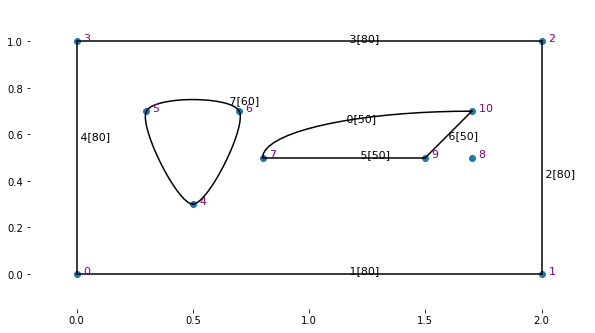

In [9]:
cfv.figure(fig_size=(10,10))
cfv.draw_geometry(g)

**Mesh**

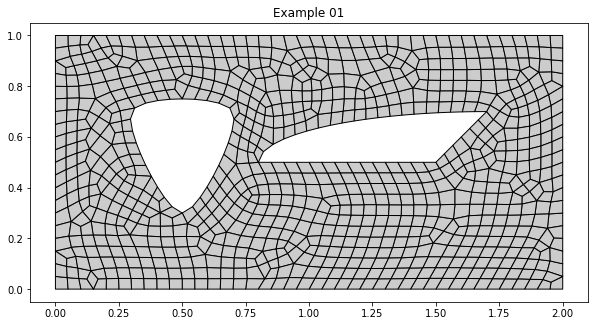

In [10]:
cfv.figure(fig_size=(10, 10))
cfv.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=True,
    title="Example 01"
)

**Temperature**

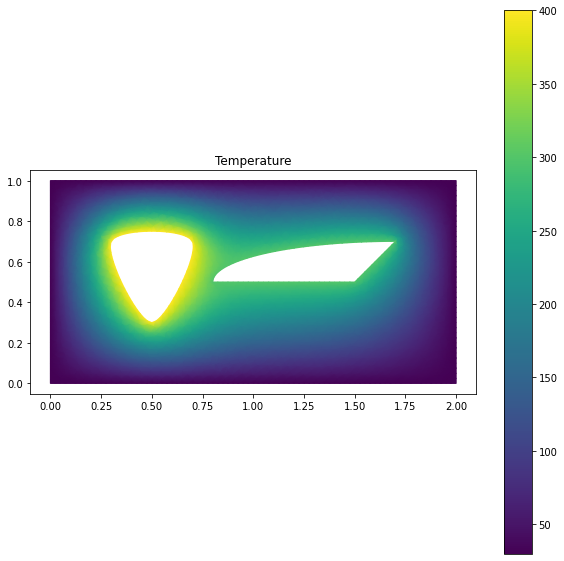

In [11]:
cfv.figure(fig_size=(10,10))
cfv.draw_nodal_values_shaded(a, coords, edof, title="Temperature")
cfv.colorbar()

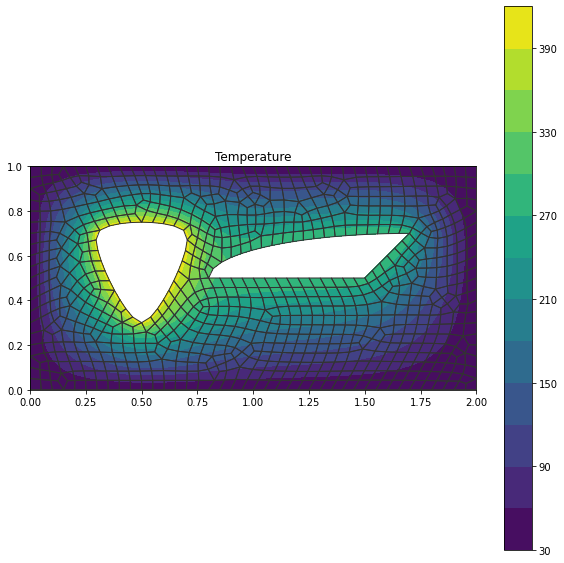

In [12]:
cfv.figure(fig_size=(10,10))
cfv.draw_nodal_values_contourf(a, coords, edof, title="Temperature", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)
cfv.colorbar()

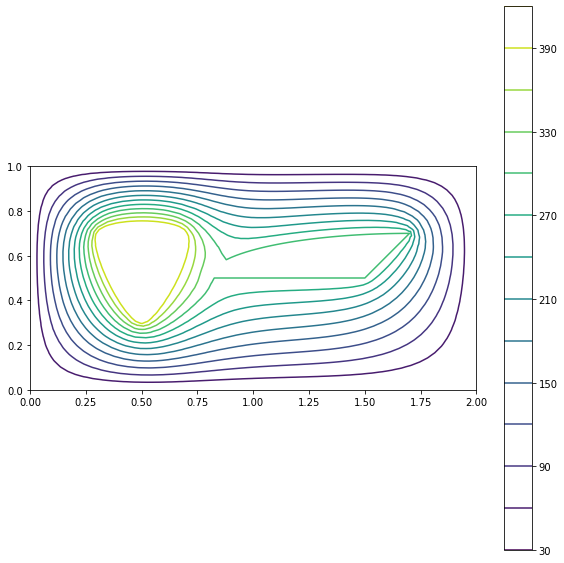

In [13]:
cfv.figure(fig_size=(10,10))
cfv.draw_nodal_values_contour(a, coords, edof)
cfv.colorbar()